In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
def load_average_scores():
    rsivl = "/ptmp/tshen/shared/RSIVL/labels.xls"
    visc = "/ptmp/tshen/shared/VISC/VISC-C/labels.csv"

    labels = {}
    labels['rsivl'] = pd.read_excel(rsivl)
    labels['rsivl'].rename(columns={'subjective scores': 'complexity', 'Unnamed: 0': 'filename'}, inplace=True)
    labels['rsivl']['filename'] = labels['rsivl']['filename'] + ".bmp"
    labels['visc'] = pd.read_csv(visc)
    labels['visc'].rename(columns={'score': 'complexity', 'image': 'filename'}, inplace=True)

    for k in labels.keys():
        assert labels[k][['filename', 'complexity']].isnull().values.any() == False

    return labels

In [3]:
def load_predictions(folder="../out/2023July20", filenames=['4points', '8points', '16points', '32points', '64points']):
    rsivl = "{}/RSIVL".format(folder)
    visc = "{}/VISC".format(folder)

    preds = {}
    
    for v, n in zip([rsivl, visc], ["rsivl", "visc"]):
        preds_dataset = []
        single_file_len = 0

        for f in filenames:
            df = pd.read_csv("{}/{}.csv".format(v, f), names=["filename", f], header=None)
            preds_dataset.append(df)
            single_file_len = len(df)

        combined_df = pd.concat([df.set_index("filename") for df in preds_dataset], axis=1, join='inner').reset_index()  # join on filename
        assert len(combined_df) == single_file_len
        assert combined_df.isnull().values.any() == False

        preds[n] = combined_df

    preds['rsivl']['filename'] = preds['rsivl']['filename'].str.replace('.json', '.bmp', regex=False)
    for k in ["visc"]:
        preds[k]['filename'] = preds[k]['filename'].str.replace('.json', '.jpg', regex=False)

    return preds

In [4]:
def load_subject_scores():
    rsivl = "/ptmp/tshen/shared/subject_level_data/rsivl_labels.csv"
    visc = "/ptmp/tshen/shared/subject_level_data/visc_labels.csv"

    labels = {}
    labels['rsivl'] = pd.read_csv(rsivl)
    labels['visc'] = pd.read_csv(visc)

    return labels

In [5]:
def join_preds_labels(preds, avg_labels, subject_labels):
    data = {}
    
    for k in ["rsivl", "visc"]:
        data[k] = pd.concat(
            [df.set_index("filename") for df in [preds[k], avg_labels[k][['filename', 'complexity']], subject_labels[k]]], 
            axis=1, join='inner').reset_index()

        if k == 'rsivl':
            data[k]['computed_average'] = data[k][['participant{}'.format(i) for i in range(1, 27)]].mean(axis=1)

        elif k == 'visc':
            data[k]['computed_average'] = data[k][['rating{}'.format(i) for i in range(1, 11)]].mean(axis=1)

        if k != 'ic9600':
            assert len(data[k]) == len(preds[k]) == len(avg_labels[k]) == len(subject_labels[k])
        else:
            pass
        assert data[k].isnull().values.any() == False

    return data

In [6]:
levels = ['4points', '8points', '16points', '32points', '64points']

In [7]:
preds = load_predictions(folder="../out/2023July20", filenames=levels)
avg_labels = load_average_scores()
subject_labels = load_subject_scores()
data = join_preds_labels(preds, avg_labels, subject_labels)


# Check whether computed averages match paper averages

In [8]:
# visc
df = pd.concat([df.set_index("filename") for df in [avg_labels['visc'], subject_labels['visc']]], axis=1, join='inner').reset_index()
matched = sum(df['average'] == df['complexity'])
print("{} images complexities matched, {} didn't".format(matched, len(df)-matched))
print(df[["filename", "complexity", "average"]])

503 images complexities matched, 297 didn't
                     filename  complexity  average
0    sun_aiztxdurlviyfwxz.jpg       52.50     52.5
1    sun_bplgyeqclqlogugd.jpg       54.40     47.5
2    sun_acdlgczjpwkeuvgy.jpg       49.92     48.8
3    sun_bhicdswlyikaabeq.jpg       52.70     52.7
4    sun_bfqkksxqisfiefwe.jpg       55.70     55.7
..                        ...         ...      ...
795  sun_bqfkrpcpakhwiilp.jpg       65.50     65.6
796  sun_bwkvdeqiygcrqwxi.jpg       62.00     66.1
797  sun_boxfizxdmlaotdgc.jpg       44.90     40.6
798  sun_bkzcruvdqfrkgnuz.jpg       51.80     51.8
799  sun_agblpzrkbqcipkyz.jpg       68.40     68.4

[800 rows x 3 columns]


In [9]:
df['computed_average'] = df[['rating{}'.format(i) for i in range(1, 11)]].mean(axis=1)
sum(df['average'] == df['computed_average']) == len(df)

True

In [10]:
# rsivl
df = pd.concat([df.set_index("filename") for df in [avg_labels['rsivl'], subject_labels['rsivl']]], axis=1, join='inner').reset_index()

In [11]:
df['computed_average'] = df[['participant{}'.format(i) for i in range(1, 27)]].mean(axis=1)
matched = sum(df['computed_average'] == df['complexity'])
print("{} images complexities matched, {} didn't".format(matched, len(df)-matched))
print(df[['filename', 'computed_average', 'complexity']])

0 images complexities matched, 49 didn't
       filename  computed_average  complexity
0   imm(01).bmp         63.730769   66.524386
1   imm(02).bmp         40.076923   38.647517
2   imm(03).bmp         32.423077   26.785901
3   imm(04).bmp         39.192308   37.909683
4   imm(05).bmp         37.615385   34.144361
5   imm(06).bmp         20.115385    9.640032
6   imm(07).bmp         73.730769   80.508480
7   imm(08).bmp         38.615385   36.031685
8   imm(09).bmp         71.269231   78.822934
9   imm(10).bmp         69.461538   75.211093
10  imm(11).bmp         54.961538   59.475811
11  imm(12).bmp         45.884615   44.216018
12  imm(13).bmp         47.884615   47.912358
13  imm(14).bmp         36.230769   35.351240
14  imm(15).bmp         80.269231   88.806936
15  imm(16).bmp         59.615385   60.658395
16  imm(17).bmp         40.730769   37.855659
17  imm(18).bmp         52.730769   55.479603
18  imm(19).bmp         59.115385   61.530974
19  imm(20).bmp      -9999.000000   55.

# Remove outliers

In [12]:
data['rsivl'] = data['rsivl'][data['rsivl'].participant1 != -9999]

In [13]:
assert len(data['rsivl']) == 48
assert (data['rsivl'] == -9999).sum(axis=0).sum() == 0

# Noise-ceiling: half-versus-half

In [17]:
def get_correlations(x, y):
    model = np.poly1d(np.polyfit(x, y, 1))                
    return stats.pearsonr(x, y), stats.spearmanr(x, y), r2_score(y, model(x))

def get_specified_cols(n_cols, choice):
    first_idxs = np.zeros(n_cols, dtype=bool)
    first_idxs[choice] = True
    second_idxs = ~first_idxs
    return first_idxs, second_idxs

def sample_random_cols(n_cols, n_first_split):
    choice = np.random.choice(range(n_cols), size=(n_first_split,), replace=False)
    return get_specified_cols(n_cols, choice)

def split_vs_split(x, first_split_size=0.5, first_split_idxs=None, n_repeats=1):
    n_ratings = x.shape[1]
    n_images = x.shape[0]

    results = []

    for _ in range(n_repeats):

        if first_split_idxs is not None:  # choosing the split columns instead of randomizing them
            first_idxs, second_idxs = get_specified_cols(n_ratings, first_split_idxs)
        else:
            first_idxs, second_idxs = sample_random_cols(n_ratings, int(first_split_size*n_ratings))
        
        first_split = x[:, first_idxs]
        second_split = x[:, second_idxs]

        first_means = first_split.mean(axis=1) if len(first_split.shape) == 2 else first_split
        second_means = second_split.mean(axis=1) if len(second_split.shape) == 2 else second_split

        # print(first_split.shape, second_split.shape, first_means.shape, second_means.shape)

        results.append(get_correlations(first_means, second_means))

    return results

In [21]:
# a, b = sample_random_cols(n_ratings, int(0.3*n_ratings))
# sum(a), sum(b), a, b, a == b
# a, b = get_specified_cols(n_ratings, [1, 3])
# sum(a), sum(b), a, b, a == b

In [22]:
def plot_corr_boxplots(results, title):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title, fontsize=14)

    for i, c in enumerate(["Pearson", "Spearman", "R^2"]):
        correlations = [x[i].statistic for x in results] if c != "R^2" else [x[i] for x in results]
        axes[i].boxplot(correlations)
        axes[i].set_xlabel(c)
        axes[i].get_xaxis().set_ticks([])

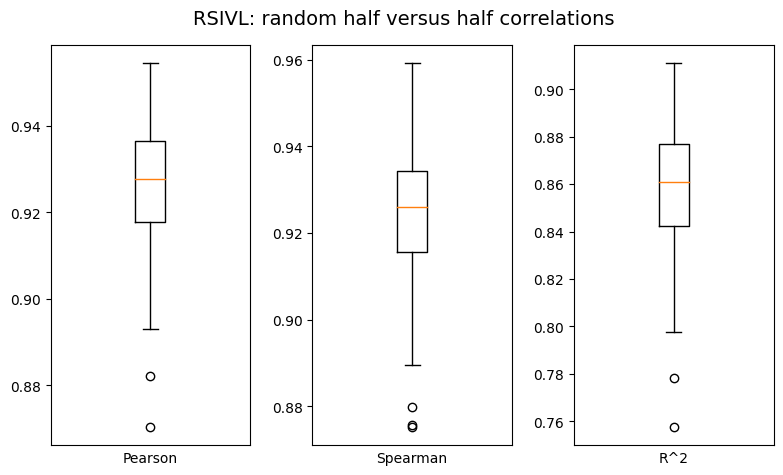

In [23]:
x = data['rsivl'][['participant{}'.format(i) for i in range(1, 27)]].to_numpy(dtype=np.float64)
results = split_vs_split(x, first_split_size=0.5, n_repeats=100)
plot_corr_boxplots(results, "RSIVL: random half versus half correlations")

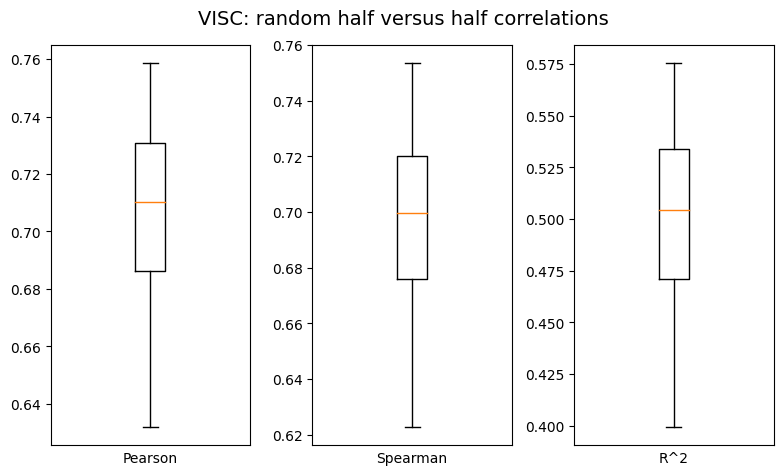

In [24]:
x = data['visc'][['rating{}'.format(i) for i in range(1, 11)]].to_numpy(dtype=np.float64)
results = split_vs_split(x, first_split_size=0.5, n_repeats=100)
plot_corr_boxplots(results, "VISC: random half versus half correlations")

# Noise-ceiling: 1-versus-rest

In [25]:
def one_vs_rest(x, n_participants):
    results = []
    for i in range(n_participants):
        results.append(split_vs_split(x, first_split_idxs=[i], n_repeats=1)[0])
    
    return results

In [26]:
def plot_scatterplots(results, n_participants, title):
    columns = ["complexity"] + levels
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
    plt.suptitle(title, fontsize=14)

    for i, c in enumerate(["Pearson", "Spearman", "R^2"]):
        correlations = [x[i].statistic for x in results] if c != "R^2" else [x[i] for x in results]
        axes[i].scatter(list(range(1, n_participants+1)), correlations)
        axes[i].set_xlabel("Participant number")
        axes[i].set_ylabel(c)

In [27]:
x = data['rsivl'][['participant{}'.format(i) for i in range(1, 27)]].to_numpy(dtype=np.float64)
results = one_vs_rest(x, 26)

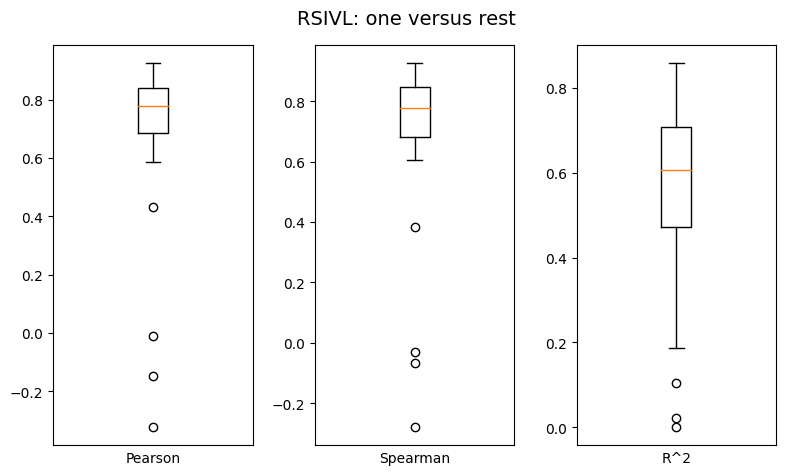

In [28]:
plot_corr_boxplots(results, "RSIVL: one versus rest")

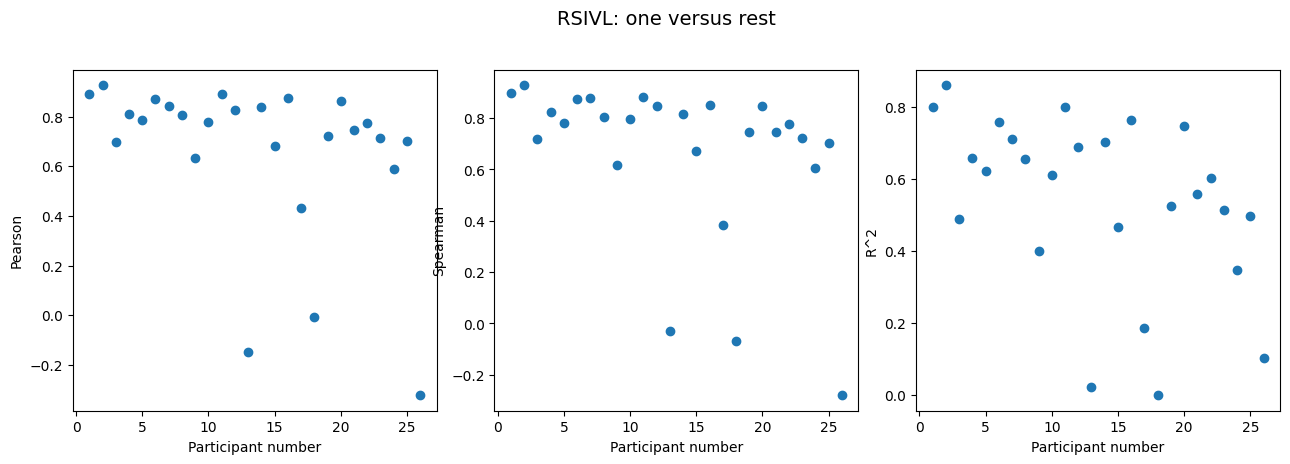

In [29]:
plot_scatterplots(results, 26, "RSIVL: one versus rest")

## Repeat with outlier participants removed

In [30]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]

In [31]:
x = data['rsivl'][['participant{}'.format(i) for i in participants]].to_numpy(dtype=np.float64)

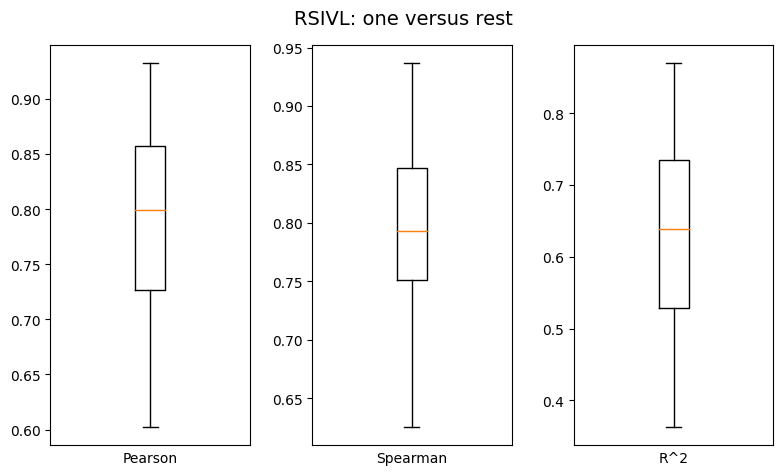

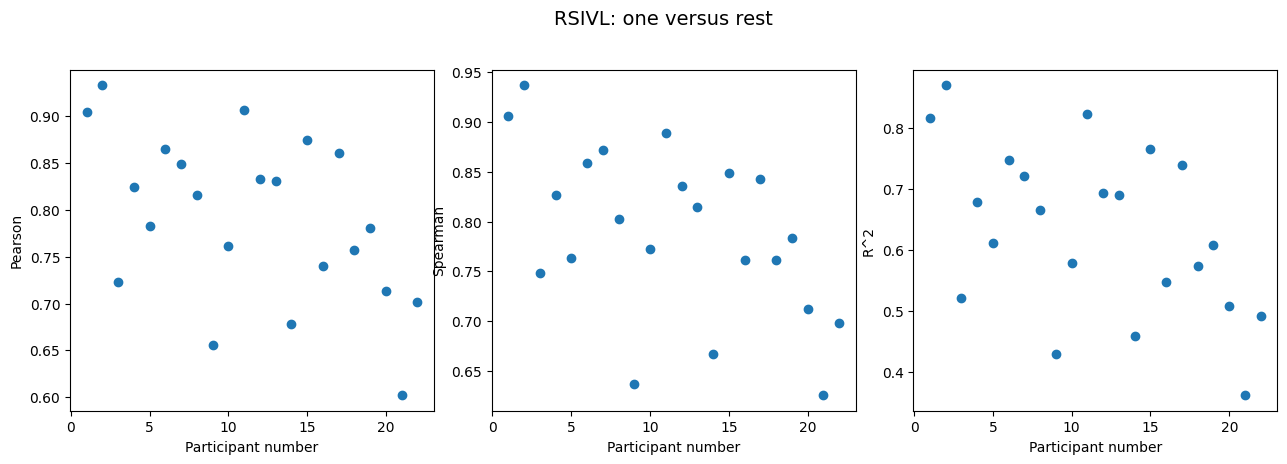

In [33]:
results = one_vs_rest(x, 22)
plot_corr_boxplots(results, "RSIVL: one versus rest")
plot_scatterplots(results, 22, "RSIVL: one versus rest")

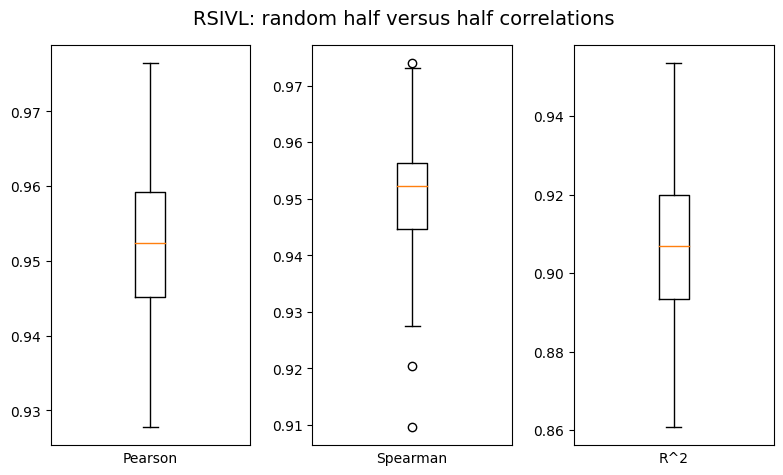

In [44]:
results = split_vs_split(x, first_split_size=0.5, n_repeats=100)
plot_corr_boxplots(results, "RSIVL: random half versus half correlations")